<h1><center><big>Semi-supervised learning : le pseudo-labeling</big> <br></center></h1>

<h3><center>Expérimentations sur CIFAR10</center></h3>
<hr>

Nous avons adapté le tutoriel pytorch pour faire du semi-supervisé : 

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Nous utiliserons CIFAR10, un jeu de données de petites images couleur de 32x32 pixels avec 10 classes différentes.

L'ensemble d'entraînement compte normalement 50 000 images et l'ensemble de test 10 000 images.

Ce jeu de données est entièrement annoté, nous allons donc supprimer artificiellement certaines étiquettes.

In [ ]:
! nvidia-smi

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm_notebook

Pour la reproductibilité : 

In [2]:
SEED=2023
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
cudnn.benchmark = True
np.random.seed(SEED)
# random.seed(SEED)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


/home/tuan-vu.tran/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Chargement de CIFAR10

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [91]:
def imshow(images, labels, predicted_labels=None):
    # Using torchvision to make a grid of the images
    img = torchvision.utils.make_grid(images)

    img = img / 2 + 0.5     # unnormalize
    img = img.permute(1, 2, 0)

    # Plotting the grid
    fig, ax = plt.subplots(figsize=(12, 48))
    plt.imshow(img)

    if predicted_labels is not None:
        # labels prédits si elles existent
        ax.set_xlabel('Predicted labels', fontsize=18, labelpad=12)
        ax.set_xticks(torch.arange(len(images)) * 35 + 20)
        ax.set_xticklabels([classes[predicted_labels[j]] 
                            for j in range(len(images))], fontsize=14)
    
    # labels ground truth 
    gax = ax.secondary_xaxis('top')
    gax.set_xlabel('Ground truth', fontsize=18, labelpad=12)
    gax.set_xticks(torch.arange(len(images)) * 35 + 20)
    gax.set_xticklabels([classes[labels[j]] for j in range(len(images))], fontsize=14)
    plt.show()

In [92]:
# Images random du train 
dataiter = iter(trainloader)
images, labels = next(dataiter)

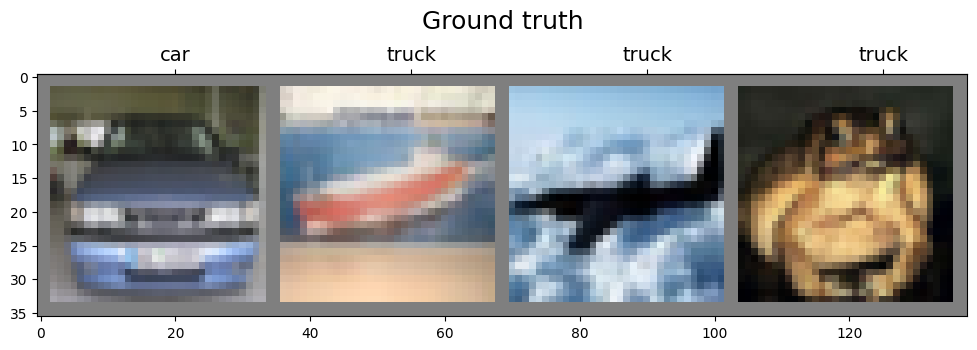

In [93]:
imshow(images[:4], labels[:4])

# Split artificiel du train

Divisons l'ensemble des données de train en : 


* exemples avec label
* exemples sans label

Comme les données sont entièrement étiquetées, nous supprimons artificiellement certaines étiquettes et leur attribuons la valeur -1.



In [39]:
# Nous ne gardons que 40% de l'ensemble des données étiquetées du train 
# Vous pourrez essayer une autre valeur par la suite 
# A priori que se passe-t-il si cette valeur est très faible ? Très élevée ?

proportion_labeled_elements = 0.4 

# on shuffle les indices :
indices = torch.randperm(len(trainset))

n_labeled_indices = int(len(indices) * proportion_labeled_elements)
indices_labeled = sorted(indices[:n_labeled_indices])
indices_unlabeled = sorted(indices[n_labeled_indices:])

for index in indices_unlabeled:
    trainset.targets[index] = -1  # on met à -1 le label (valeur arbitraire, on la remplacera pour un label prédit par la suite)

dataset_train_labeled = torch.utils.data.Subset(trainset, indices_labeled)
dataset_train_unlabeled = torch.utils.data.Subset(trainset, indices_unlabeled)


In [55]:
len(dataset_train_labeled), len(dataset_train_unlabeled)

(20000, 30000)

In [56]:
train_loader_labeled = torch.utils.data.DataLoader(dataset_train_labeled, batch_size=batch_size, shuffle=True)

# Pas de shuffle sur la data loader des unlabeled, sinon on ne pourra pas les remplacer facilement par des labels prédits
train_loader_unlabeled = torch.utils.data.DataLoader(dataset_train_unlabeled, batch_size=batch_size)  

# Définition d'un petit CNN

Vous pourrez par la suite essayer un modèle standard, comme un ResNet, pré-entraîné sur ImageNet ou non. 

Voir si le pseudo-labeling que l'on fait ici avec un tout petit modèle marche aussi avec un plus gros modèle comme ResNet.
 

In [275]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [276]:
def train(testloader, trainloader, model, opt, crit, n_epoch=2, loss_every=20):
    """
    Entraînement d'un modèle et plot des courbes de loss et accuracy
    """
    model.train()
    losses = []
    acc = []
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        print(f"Epoch {epoch}.")
    
        running_loss = []
        running_acc = []
        print("Train.")
        for i, data in tqdm_notebook(enumerate(trainloader), total=len(trainloader)):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Mettre à zero les gradients des poids du modèle
            opt.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()
            # print("out ", outputs)
            predicted = torch.argmax(outputs, dim=1)
            # print("predicted ", predicted)

            running_loss.append(loss.item())
            running_acc.append((predicted == labels).sum().item() / labels.size(0))

            # calculer une moyenne 
            if i % loss_every == 0:
                losses.append(np.mean(running_loss))
                acc.append(np.mean(running_acc))

                running_loss = []
                running_acc = []

        test_acc = accuracy(testloader, model)
        print(f"Test accuracy: {test_acc:.3f}")

    fig, axes = plt.subplots(2, 1)
    axes[0].plot(losses)
    axes[1].plot(acc)

    axes[0].set_ylabel("Train loss")
    axes[1].set_ylabel("Train acc")
    plt.show()
    print('Apprentissage terminé')

def accuracy(loader, model):
    """
    Args:
        loader: data loader sur lequel on veut calculer une accuracy
        model
    Returns:
        Accuracy 
    """
    with torch.no_grad():
        model.eval()  # remove potential dropout, ...
        n_correct = 0
        n_total = 0
        for i, data in tqdm_notebook(enumerate(loader), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # forward + backward + optimize
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            n_correct += (predicted == labels).sum()
            n_total += labels.size(0)
        return n_correct / n_total


def validate(loader, model):
    """
    Plot des predictions faites avec model, affiche l'accuracy
    """
    dataiter = iter(loader)
    # Get one batch of data
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)

    accuracy_model = accuracy(loader, model)
    
    # print images
    print(f'Accuracy: {accuracy_model.detach().cpu().item():.3f}')

    imshow(images[:4].detach().cpu(), labels[:4], predicted_labels=predictions[:4])


# Train sur le train avec labels (les 40 % du train supervisé)

In [277]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [278]:
20*625

12500

Epoch 0.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.178
Epoch 1.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.288
Epoch 2.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.329
Epoch 3.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.371
Epoch 4.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.411
Epoch 5.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.441
Epoch 6.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.458
Epoch 7.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.477
Epoch 8.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.470
Epoch 9.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.493


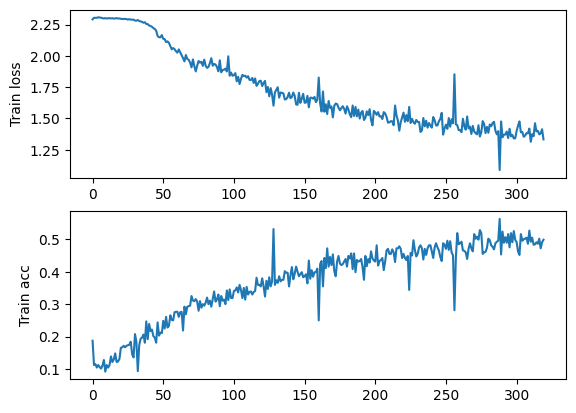

Apprentissage terminé


In [279]:
train(testloader, train_loader_labeled, net, optimizer, criterion, n_epoch=10)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.493


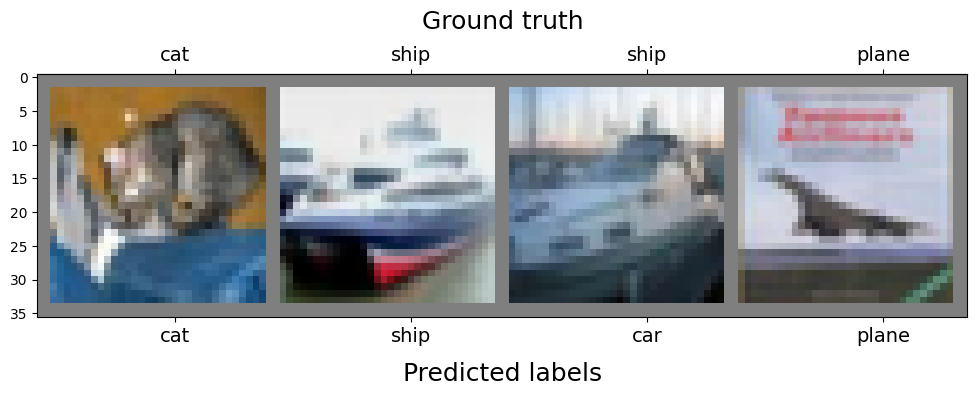

In [280]:
validate(testloader, net)

# Utiliser le modèle sur le train unlabeled et utiliser les labels prédits

In [285]:
def label_dataset(loader, model):
    """
    Retourne les prédictions sur un subset donné par loader 
    """
    with torch.no_grad():
        model.eval()
        all_labels = []
        for i, data in tqdm_notebook(enumerate(loader), total=len(loader)):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            all_labels.append(predicted)
        return torch.cat(all_labels, dim=0)


In [286]:
labels = label_dataset(train_loader_unlabeled, net)

  0%|          | 0/938 [00:00<?, ?it/s]

Remplaçons les labels dans trainset par les labels prédits, souvent appelées des "pseudo-labels", pour les exemples unlabeled

In [287]:
for k, index in enumerate(indices_unlabeled):
    trainset.targets[index] = labels[k].item()

# Entraînement d'un modèle avec la partie labeled + la partie unlabeled avec les "pseudo-labels"

In [288]:
net2 = Net().to(device)
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

Epoch 0.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.282
Epoch 1.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.412
Epoch 2.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.461
Epoch 3.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.477
Epoch 4.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.489
Epoch 5.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.491
Epoch 6.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.504
Epoch 7.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.506
Epoch 8.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.507
Epoch 9.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.507


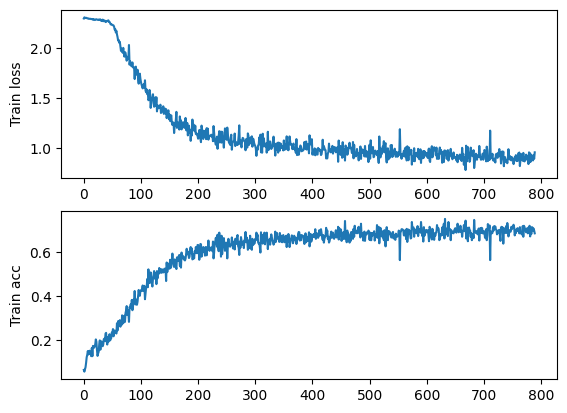

Apprentissage terminé


In [289]:
train(testloader, trainloader, net2, optimizer, criterion, n_epoch=10)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.507


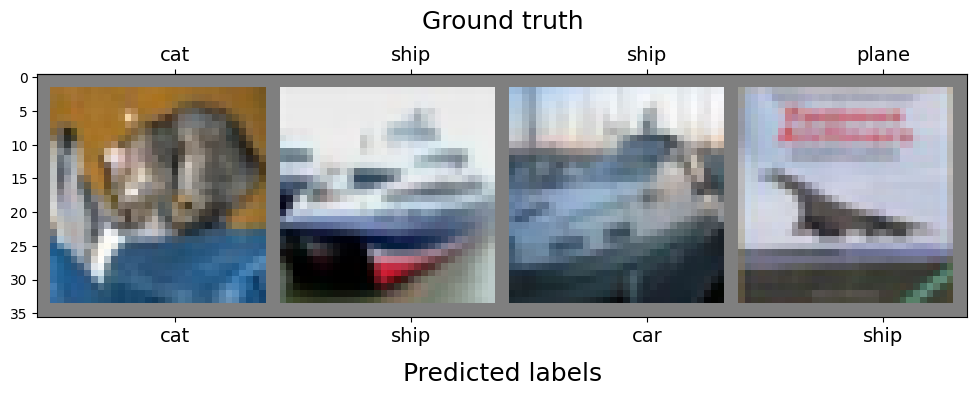

In [291]:
validate(testloader, net2)

L'accuracy doit être meilleure, le pseudo-labeling aide !

# Comparaison avec un modèle entraîné sur 100 % du train avec les vraies labels 

In [292]:
net3 = Net().to(device)
optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

In [293]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


Epoch 0.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.177
Epoch 1.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.340
Epoch 2.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.411
Epoch 3.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.464
Epoch 4.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.502
Epoch 5.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.523
Epoch 6.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.550
Epoch 7.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.580
Epoch 8.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.587
Epoch 9.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.603


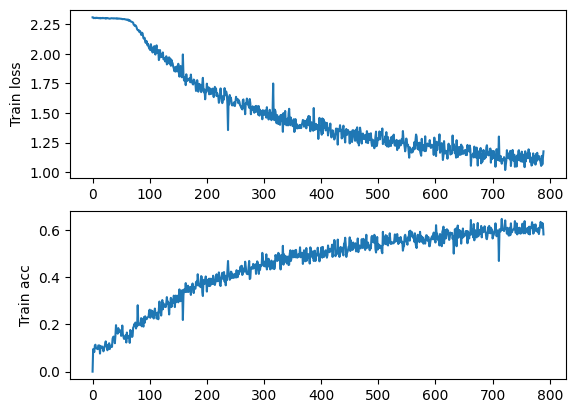

Apprentissage terminé


In [294]:
train(testloader, trainloader, net3, optimizer, criterion, n_epoch=10)

On obtient environ 10 points de mieux quand même que précedemment !